In [413]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

Loading the data

In [414]:
from sklearn.datasets import load_digits
digits = load_digits()

In [415]:
y=digits.target
X=digits.data

In [416]:
y = np.array(y)
X= np.array(X)

In [417]:
#split data into a training set (70%) and a testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1,stratify=y)
#Using such a fixed random_state ensures that our results are reproducible.

In [418]:
#stratify=y enables stratification: returns training and test subsets that have the
#same proportions of class labels as the input dataset.

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [178 182 177 183 181 182 181 179 174 180]
Labels counts in y_train: [124 127 124 128 127 127 127 125 122 126]
Labels counts in y_test: [54 55 53 55 54 55 54 54 52 54]


In [419]:
# stack image pixels column-wise
print(X_train.shape)
print(X_test.shape)

(1257, 64)
(540, 64)


1-Logistic Regression on the digits

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Stack image pixels into a 64x1 vector
X_train = X_train.reshape((-1, 64))
X_test = X_test.reshape((-1, 64))
# stack image pixels column-wise
print(X_train.shape)
print(X_test.shape)

model = LogisticRegression(penalty='elasticnet', solver='saga',max_iter=5000)

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

#  find the optimal values 
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy)

Best hyperparameters: {'C': 0.01, 'l1_ratio': 0}
Test accuracy: 0.9666666666666667


2-MLP Neural Network

In [420]:
# PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)


In [421]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        previous_layer_size = input_size
        for hidden_layer_size in hidden_layers:
            layers.append(nn.Linear(previous_layer_size, hidden_layer_size))
            layers.append(nn.ReLU())
            previous_layer_size = hidden_layer_size
        layers.append(nn.Linear(previous_layer_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [422]:
# Train an MLP model 
def train_mlp(hidden_layers, epochs=100):
    model = MLP(64, hidden_layers, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        accuracy = accuracy_score(y_train, torch.argmax(output, dim=1))
        train_accuracy.append(accuracy)

    return model, train_loss, train_accuracy

In [423]:
param_grid = {
    'hidden_layers': [(n,) for n in range(50, 201, 50)] + [(n, n) for n in range(50, 201, 50)],
    'epochs': [50, 100, 200]
}

# Grid search the MLP
best_accuracy = 0
best_model = None
best_train_loss = []
best_train_accuracy = []
best_config = None

for hidden_layers in param_grid['hidden_layers']:
    for epochs in param_grid['epochs']:
        model, train_loss, train_accuracy = train_mlp(hidden_layers, epochs)
        accuracy = accuracy_score(y_test, torch.argmax(model(X_test), dim=1))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_train_loss = train_loss
            best_train_accuracy = train_accuracy
            best_config = {'hidden_layers': hidden_layers, 'epochs': epochs}

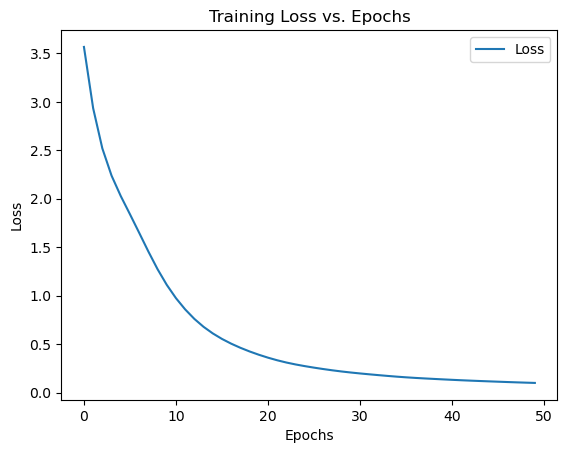

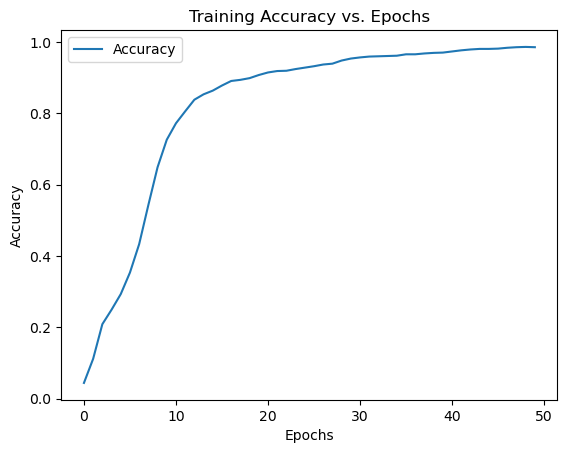

In [424]:
# Plot of the training loss and accuracy versus the number of epochs 
plt.figure()
plt.plot(best_train_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(best_train_accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.show()

In [425]:
test_accuracy = accuracy_score(y_test, torch.argmax(best_model(X_test), dim=1))
print("Best configuration:", best_config)
print("Accuracy on test data:", test_accuracy)

Best configuration: {'hidden_layers': (200,), 'epochs': 50}
Accuracy on test data: 0.975925925925926


In [426]:
import torch.nn.functional as F

# Reshape for CNN
X_train, X_test = X_train.view(-1, 1, 8, 8), X_test.view(-1, 1, 8, 8)

# Create a custom CNN class
class CNN(nn.Module):
    def __init__(self, conv_layers):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for in_channels, out_channels in conv_layers])
        self.fc = nn.Linear(8 * 8 * conv_layers[-1][-1], 10)
        
    def forward(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [427]:
# Train the CNN 
def train_cnn(conv_layers, epochs=100):
    model = CNN(conv_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        accuracy = accuracy_score(y_train, torch.argmax(output, dim=1))
        train_accuracy.append(accuracy)

    return model, train_loss, train_accuracy

In [428]:
param_grid = {
    'conv_layers': [
        [(1, 16)],
        [(1, 16), (16, 32)]
    ],
    'epochs': [50, 100, 200]
}

# Grid search  the CNN
best_accuracy = 0
best_model = None
best_train_loss = []
best_train_accuracy = []
best_config = None

for conv_layers in param_grid['conv_layers']:
    for epochs in param_grid['epochs']:
        model, train_loss, train_accuracy = train_cnn(conv_layers, epochs)
        accuracy = accuracy_score(y_test, torch.argmax(model(X_test), dim=1))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_train_loss = train_loss
            best_train_accuracy = train_accuracy
            best_config = {'conv_layers': conv_layers, 'epochs': epochs}

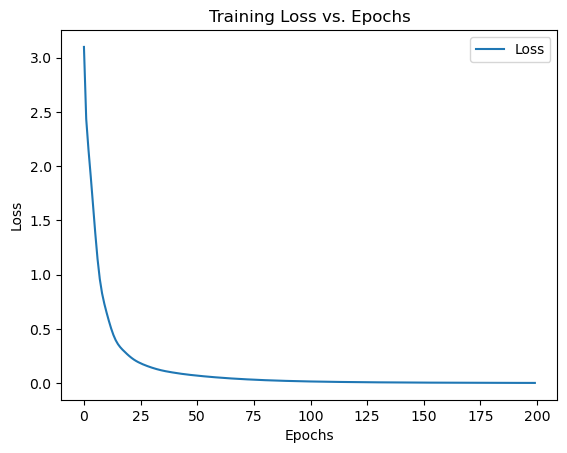

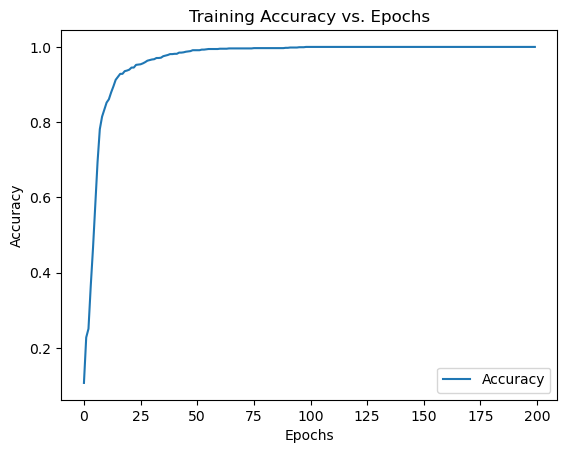

In [429]:
# Plot of the training loss and accuracy versus the number of epochs 
plt.figure()
plt.plot(best_train_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()

plt.figure()
plt.plot(best_train_accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.legend()
plt.show()

In [430]:
test_accuracy = accuracy_score(y_test, torch.argmax(best_model(X_test), dim=1))
print("Best configuration:", best_config)
print("Accuracy on test data:", test_accuracy)

Best configuration: {'conv_layers': [(1, 16)], 'epochs': 200}
Accuracy on test data: 0.9796296296296296
